INSTALL DEPENDENCIES (to be run only once in terminal)

In [1]:
"""!pip install torch
!pip install pandas numpy scikit-learn
!pip install matplotlib seaborn
!pip install tqdm """


'!pip install torch\n!pip install pandas numpy scikit-learn\n!pip install matplotlib seaborn\n!pip install tqdm '

IMPORT LIBRARIES

In [2]:
# Basic utilities
import os
import re
import json
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

# PyTorch core
import torch
from torch.utils.data import Dataset, DataLoader

# Evaluation helpers
from sklearn.model_selection import train_test_split


DATASET INTEGRATION

In [3]:
# Load the IMDB movie review dataset
df = pd.read_csv("IMDB Dataset.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Check sentiment distribution
df["sentiment"].value_counts()


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

TEXT PREPROCESSING

In [5]:
def clean_text(text):
    # Normalize case to reduce vocabulary size
    text = text.lower()
    
    # Remove HTML tags commonly present in IMDB reviews
    text = re.sub(r"<.*?>", "", text)
    
    # Keep only alphabetic characters and spaces
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

df["clean_review"] = df["review"].apply(clean_text)

In [6]:
# Compare raw vs cleaned text
df[["review", "clean_review"]].head()


,review,clean_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...


TOKENIZATION

In [7]:
def tokenize(text):
    return text.split()

df["tokens"] = df["clean_review"].apply(tokenize)
df[["clean_review", "tokens"]].head()


,clean_review,tokens
0,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione..."
1,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin..."
2,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,..."
3,basically theres a family where a little boy j...,"[basically, theres, a, family, where, a, littl..."
4,petter matteis love in the time of money is a ...,"[petter, matteis, love, in, the, time, of, mon..."


VOCABULARY CREATION

In [8]:
from collections import Counter

word_freq = Counter()

# Count word frequencies across the entire corpus
for tokens in df["tokens"]:
    word_freq.update(tokens)

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# Initialize vocabulary with special tokens
vocab = {
    PAD_TOKEN: 0,
    UNK_TOKEN: 1
}

# Add words to vocabulary based on frequency threshold
for word, freq in word_freq.items():
    if freq >= 2:  # removes very rare/noisy words
        vocab[word] = len(vocab)

print("Vocabulary size:", len(vocab))


Vocabulary size: 81589


In [9]:
list(vocab.items())[:10]

[('<PAD>', 0),
 ('<UNK>', 1),
 ('one', 2),
 ('of', 3),
 ('the', 4),
 ('other', 5),
 ('reviewers', 6),
 ('has', 7),
 ('mentioned', 8),
 ('that', 9)]

In [10]:
# Save vocabulary for reuse in training and inference
with open("vocab.json", "w") as f:
    json.dump(vocab, f)

print("Vocabulary saved as vocab.json")


Vocabulary saved as vocab.json


SEQUENCE ENCODING

In [11]:
# Encode tokens to their corresponding integer IDs
def encode_tokens(tokens, vocab):
    return [vocab.get(word, vocab["<UNK>"]) for word in tokens]

df["encoded"] = df["tokens"].apply(lambda x: encode_tokens(x, vocab))
df[["tokens", "encoded"]].head()

,tokens,encoded
0,"[one, of, the, other, reviewers, has, mentione...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,"[a, wonderful, little, production, the, filmin...","[49, 188, 189, 190, 4, 191, 192, 23, 193, 194,..."
2,"[i, thought, this, was, a, wonderful, way, to,...","[136, 265, 22, 34, 49, 188, 266, 60, 267, 268,..."
3,"[basically, theres, a, family, where, a, littl...","[342, 343, 49, 344, 85, 49, 189, 345, 346, 347..."
4,"[petter, matteis, love, in, the, time, of, mon...","[1, 388, 389, 43, 4, 268, 3, 390, 23, 49, 391,..."


PADDING & TRUNCATION

In [12]:
#Make all sequences equal-length and model-ready
# Pad or truncate sequences to a fixed length
MAX_LEN = 500

def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        return seq + [vocab["<PAD>"]] * (max_len - len(seq))
    return seq[:max_len]

df["padded"] = df["encoded"].apply(lambda x: pad_sequence(x, MAX_LEN))
df[["encoded", "padded"]].head()

,encoded,padded
0,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,"[49, 188, 189, 190, 4, 191, 192, 23, 193, 194,...","[49, 188, 189, 190, 4, 191, 192, 23, 193, 194,..."
2,"[136, 265, 22, 34, 49, 188, 266, 60, 267, 268,...","[136, 265, 22, 34, 49, 188, 266, 60, 267, 268,..."
3,"[342, 343, 49, 344, 85, 49, 189, 345, 346, 347...","[342, 343, 49, 344, 85, 49, 189, 345, 346, 347..."
4,"[1, 388, 389, 43, 4, 268, 3, 390, 23, 49, 391,...","[1, 388, 389, 43, 4, 268, 3, 390, 23, 49, 391,..."


TEXT EXPLORATORY DATA ANALYSIS

In [13]:
# Analyze review length distribution
review_lengths = df["tokens"].apply(len)

print("Min length:", review_lengths.min())
print("Max length:", review_lengths.max())
print("Average length:", int(review_lengths.mean()))
print("95th percentile length:", int(np.percentile(review_lengths, 95)))


Min length: 4
Max length: 2441
Average length: 225
95th percentile length: 575


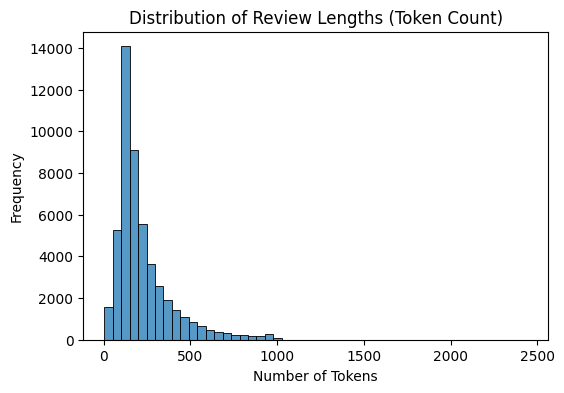

In [14]:
# Visualize review length distribution
plt.figure(figsize=(6,4))
sns.histplot(review_lengths, bins=50)
plt.title("Distribution of Review Lengths (Token Count)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()


LABEL ENCODING

In [15]:
# Encode sentiment labels: positive → 1, negative → 0
labels = (df["sentiment"] == "positive").astype(int).values

# Sanity check
np.unique(labels, return_counts=True)


(array([0, 1]), array([25000, 25000]))

TRAIN–VALIDATION SPLIT

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df["padded"].tolist(),
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))


Train samples: 40000
Validation samples: 10000


PYTORCH DATASET & DATALOADER

In [17]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


In [18]:
train_dataset = IMDBDataset(X_train, y_train)
val_dataset   = IMDBDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))


Train batches: 1250
Validation batches: 313


EXPORT AND SAVE

In [19]:
# Save cleaned text
df["clean_review"].to_csv("Cleaned_text.txt", index=False, header=False)

# Save token IDs
df["encoded"].apply(lambda x: " ".join(map(str, x))).to_csv(
    "token_ids.txt", index=False, header=False
)
